In [41]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score

In [42]:
import os
def read_dataset(folder_path):
    data_dict = {}
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            data_dict[filename] = df.astype(float)
    return data_dict

ds = {}
dsLists = ["AICU","Automatoes","Digilog","IUACAAS","Reference","TheAutomators"]
for name in dsLists:
    folder_path = f"../{name}"
    data_dict = read_dataset(folder_path)
    ds[name] = data_dict

C:\Users\thanh\AppData\Local\Temp\ipykernel_32476\137350966.py:7: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\thanh\AppData\Local\Temp\ipykernel_32476\137350966.py:7: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\thanh\AppData\Local\Temp\ipykernel_32476\137350966.py:7: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\thanh\AppData\Local\Temp\ipykernel_32476\137350966.py:7: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31

In [43]:
class ResourcePredictor(nn.Module):
    def __init__(self, input_size=50, hidden_size=64, output_size=1, num_layers=3):
        super(ResourcePredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)              # hn shape: (num_layers, batch, hidden)
        out = self.fc(hn[-1])                  # use last hidden state
        return out                             # output shape: (batch, 3)


In [44]:
def load_and_scale_data(df, features):
    data = df[features].copy()
    data = data.interpolate(method='linear')
    data = data.fillna(method='bfill').fillna(method='ffill')
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    df_scaled = pd.DataFrame(data_scaled, columns=features, index=data.index)
    return df_scaled, scaler

# === STEP 2: Align 288 rows of df_x to 1 row of df_y ===
def align_5min_with_daily(df_x, df_y, input_seq_len=288):
    num_days = len(df_x) // input_seq_len
    df_x = df_x.iloc[:num_days * input_seq_len]
    df_y = df_y.iloc[:num_days]

    X, Y = [], []
    for i in range(num_days):
        x_seq = df_x.iloc[i*input_seq_len : (i+1)*input_seq_len].values  # (288, 7)
        y_target = df_y.iloc[i].values  # (5,)
        X.append(x_seq)
        Y.append(y_target)
    return np.array(X), np.array(Y)

# === STEP 3: Reshape for LSTM ===
def reshape_for_lstm(X, Y):
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

In [45]:
def train_model(model, train_loader, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available(): 
        print(f"Training on {torch.cuda.get_device_name(0)}")
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_targets = []

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            all_preds.append(pred.detach().cpu().numpy())
            all_targets.append(yb.detach().cpu().numpy())

        # Gộp lại để tính metrics
        y_true = np.vstack(all_targets)
        y_pred = np.vstack(all_preds)
        rmse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
    return y_true, y_pred  # return for visualization


In [70]:
df_X = ds["Digilog"]["GreenhouseClimate.csv"][["int_blue_sp","int_red_sp","int_farred_sp","int_white_sp"]]
df_Y = ds["Digilog"]["Resources.csv"]

features_X = df_X.columns
features_Y = ["ElecHigh"]
# Preprocess
df_x, scaler_x = load_and_scale_data(df_X, features_X)
df_y, scaler_y = load_and_scale_data(df_Y, features_Y)

# Build LSTM dataset
X_np, Y_np = align_5min_with_daily(df_x, df_y, input_seq_len=288)
X_tensor, Y_tensor = reshape_for_lstm(X_np, Y_np)

# Train/test split (optional)
split_idx = int(len(X_tensor) * 0.8)
train_dataset = TensorDataset(X_tensor[:split_idx], Y_tensor[:split_idx])
test_X = X_tensor[split_idx:]
test_Y = Y_tensor[split_idx:]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Khởi tạo và train model
model = ResourcePredictor()
y_true, y_pred = train_model(model, train_loader, epochs=200)

C:\Users\thanh\AppData\Local\Temp\ipykernel_32476\3935727767.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill').fillna(method='ffill')
C:\Users\thanh\AppData\Local\Temp\ipykernel_32476\3935727767.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill').fillna(method='ffill')


Training on NVIDIA GeForce RTX 3060 Laptop GPU


RuntimeError: input.size(-1) must be equal to input_size. Expected 50, got 4

In [56]:
# Sửa đổi quy trình
df_X = ds["Digilog"]["GreenhouseClimate.csv"][["int_blue_sp","int_red_sp","int_farred_sp","int_white_sp"]]
df_Y = ds["Digilog"]["Resources.csv"]

# CHIA TRAIN/TEST TRƯỚC KHI SCALE
split_idx = int(len(df_Y) * 0.8)
X_train_df, X_test_df = df_X.iloc[:split_idx*288], df_X.iloc[split_idx*288:]
y_train_df, y_test_df = df_Y.iloc[:split_idx], df_Y.iloc[split_idx:]

# Xử lý missing values
X_train_df = X_train_df.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
X_test_df = X_test_df.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
# ... làm tương tự cho y_train_df và y_test_df

# Khởi tạo scaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit scaler CHỈ trên dữ liệu train
X_train_scaled = scaler_x.fit_transform(X_train_df)
y_train_scaled = scaler_y.fit_transform(y_train_df[['ElecHigh']])

# Transform dữ liệu test
X_test_scaled = scaler_x.transform(X_test_df)
y_test_scaled = scaler_y.transform(y_test_df[['ElecHigh']])

# Chuyển lại thành DataFrame để align
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=df_X.columns)
# ...

C:\Users\thanh\AppData\Local\Temp\ipykernel_32476\2506419035.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_train_df = X_train_df.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\thanh\AppData\Local\Temp\ipykernel_32476\2506419035.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test_df = X_test_df.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')


In [63]:
num_features = 1
y_true_reshaped = y_true.reshape(-1, num_features)
y_pred_reshaped = y_pred.reshape(-1, num_features)


In [64]:
import matplotlib.pyplot as plt

def plot_feature_predictions(y_true_all, y_pred_all, feature_names, num_samples=100):
    """
    Plot predictions vs actuals for each feature.
    """
    for i, feature in enumerate(feature_names):
        plt.figure(figsize=(10, 4))
        plt.plot(y_true_all[:num_samples, i], label="Actual", linewidth=2)
        plt.plot(y_pred_all[:num_samples, i], label="Predicted", linestyle="--")
        plt.title(f"Predicted vs Actual: {feature}")
        plt.xlabel("Sample Index")
        plt.ylabel("Normalized Value")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


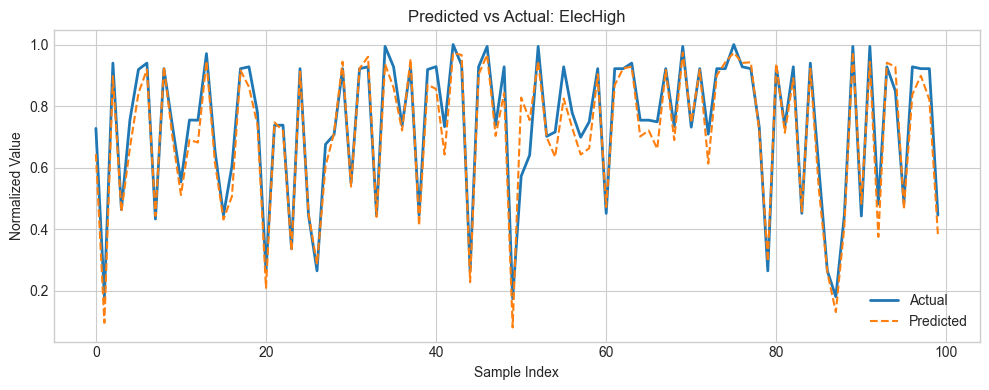

In [65]:
features = ["ElecHigh"]  # Chỉ có một feature trong trường hợp này
plot_feature_predictions(y_true_reshaped, y_pred_reshaped, features)


In [66]:
torch.save(model.state_dict(), "sensor_predictor.pth")

AttributeError: 'RandomForestRegressor' object has no attribute 'state_dict'

In [71]:
import torch
import torch.nn as nn

class GRUPredictor(nn.Module):
    def __init__(self, input_size, hidden_size1=128, hidden_size2=64, dense_size=64, output_size=1, dropout=0.2):
        super(GRUPredictor, self).__init__()
        self.gru1 = nn.GRU(input_size=input_size, hidden_size=hidden_size1,
                           batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(dropout)
        self.gru2 = nn.GRU(input_size=hidden_size1, hidden_size=hidden_size2,
                           batch_first=True, bidirectional=False)
        self.fc1 = nn.Linear(hidden_size2, dense_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(dense_size, output_size)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        out, _ = self.gru1(x)         # (batch, seq_len, hidden1)
        out = self.dropout(out)
        out, _ = self.gru2(out)       # (batch, seq_len, hidden2)
        out = out[:, -1, :]           # Lấy output tại bước thời gian cuối (batch, hidden2)
        out = self.fc1(out)           # (batch, dense)
        out = self.relu(out)
        out = self.fc2(out)           # (batch, output_size)
        return out


In [72]:
model = GRUPredictor(input_size=50)  # input_size = số features

y_true, y_pred = train_model(model, train_loader, epochs=200)

Training on NVIDIA GeForce RTX 3060 Laptop GPU


RuntimeError: input.size(-1) must be equal to input_size. Expected 50, got 4

In [73]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
X_ml = X_np.reshape(166, -1)
Y_ml = Y_np
print(f'X shape: {X_ml.shape}')
print(f'Y shape: {Y_ml.shape}')
# Khởi tạo và huấn luyện mô hình
# Create and train the Random Forest model
X_train, X_test, Y_train, Y_test = train_test_split(X_ml, Y_ml, test_size=0.2, random_state=42)

# Create and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_r2 = r2_score(Y_train, train_pred)
test_r2 = r2_score(Y_test, test_pred)

print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

feature_names = [f"f{i}" for i in range(X_train.shape[1])]

# Convert to DataFrame
X_train_df = pd.DataFrame(X_train, columns=feature_names)
feature_scores = pd.Series(model.feature_importances_, index=X_train_df.columns).sort_values(ascending=False)

print("--- Feature Importance Scores ---")
print(np.count_nonzero(feature_scores))

X shape: (166, 1152)
Y shape: (166, 1)


c:\Users\thanh\miniconda3\envs\ds-project\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Train R²: 0.8403
Test R²: 0.7231
--- Feature Importance Scores ---
832


In [74]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split # Chỉ dùng cho phiên bản gốc để so sánh
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# --- BƯỚC 1: TẢI VÀ CHIA DỮ LIỆU TRƯỚC KHI SCALE ---
df_X_raw = ds["Digilog"]["GreenhouseClimate.csv"][["int_blue_sp","int_red_sp","int_farred_sp","int_white_sp"]]
df_Y_raw = ds["Digilog"]["Resources.csv"][["ElecHigh"]]

# Xử lý missing values trước
df_X_raw = df_X_raw.interpolate(method='linear').bfill().ffill()
df_Y_raw = df_Y_raw.interpolate(method='linear').bfill().ffill()

# Chia dữ liệu theo thứ tự thời gian (phương pháp đúng)
split_idx_daily = int(len(df_Y_raw) * 0.8)
split_idx_5min = split_idx_daily * 288

X_train_df = df_X_raw.iloc[:split_idx_5min]
X_test_df = df_X_raw.iloc[split_idx_5min:]

y_train_df = df_Y_raw.iloc[:split_idx_daily]
y_test_df = df_Y_raw.iloc[split_idx_daily:]

# --- BƯỚC 2: SCALE DỮ LIỆU ĐÚNG CÁCH ---
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit scaler CHỈ trên tập train
X_train_scaled = scaler_x.fit_transform(X_train_df)
y_train_scaled = scaler_y.fit_transform(y_train_df)

# Transform tập test
X_test_scaled = scaler_x.transform(X_test_df)
y_test_scaled = scaler_y.transform(y_test_df)

# --- BƯỚC 3: ALIGN DỮ LIỆU 5-PHÚT VÀ HÀNG NGÀY ---
# Hàm align_5min_with_daily từ notebook của bạn
def align_5min_with_daily(df_x, df_y, input_seq_len=288):
    # Cần chuyển df_x từ mảng numpy về dataframe để hàm hoạt động
    df_x_pd = pd.DataFrame(df_x) 
    df_y_pd = pd.DataFrame(df_y)
    num_days = len(df_x_pd) // input_seq_len
    df_x_aligned = df_x_pd.iloc[:num_days * input_seq_len]
    df_y_aligned = df_y_pd.iloc[:num_days]
    X, Y = [], []
    for i in range(num_days):
        x_seq = df_x_aligned.iloc[i*input_seq_len : (i+1)*input_seq_len].values
        y_target = df_y_aligned.iloc[i].values
        X.append(x_seq)
        Y.append(y_target)
    return np.array(X), np.array(Y)

# Tạo dữ liệu dạng chuỗi 3D
X_train_np, Y_train_np = align_5min_with_daily(X_train_scaled, y_train_scaled)
X_test_np, Y_test_np = align_5min_with_daily(X_test_scaled, y_test_scaled)

print(f"Hình dạng dữ liệu chuỗi 3D cho Train: X={X_train_np.shape}, Y={Y_train_np.shape}")
print(f"Hình dạng dữ liệu chuỗi 3D cho Test: X={X_test_np.shape}, Y={Y_test_np.shape}")

Hình dạng dữ liệu chuỗi 3D cho Train: X=(132, 288, 4), Y=(132, 1)
Hình dạng dữ liệu chuỗi 3D cho Test: X=(34, 288, 4), Y=(34, 1)


In [80]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# --- Dữ liệu ban đầu (giả sử đã được tải vào df_X_raw và df_Y_raw) ---
df_X_raw = ds["Digilog"]["GreenhouseClimate.csv"]

df_Y_raw = ds["Digilog"]["Resources.csv"][["ElecHigh","ElecLow"]] 
df_Y_raw["Total_Elec"] = df_Y_raw["ElecHigh"]+df_Y_raw["ElecLow"]
df_Y_raw = df_Y_raw.drop(columns=["ElecLow","ElecHigh"])
# Xử lý missing values cơ bản
df_X_raw = df_X_raw.interpolate(method='linear').bfill().ffill()
df_Y_raw = df_Y_raw.interpolate(method='linear').bfill().ffill()


# --- BƯỚC 1: KỸ THUẬT ĐẶC TRƯNG (FEATURE ENGINEERING) CHO ELECHIGH ---
print("--- Bước 1: Tạo các đặc trưng Lag và Rolling cho ElecHigh ---")

# Tạo một bản sao để làm việc
df_Y_featured = df_Y_raw.copy()

# Tạo các đặc trưng trễ (lag features)
df_Y_featured['Total_Elec_lag1'] = df_Y_raw['Total_Elec'].shift(1)
df_Y_featured['Total_Elec_lag2'] = df_Y_raw['Total_Elec'].shift(2)
df_Y_featured['Total_Elec_lag7'] = df_Y_raw['Total_Elec'].shift(7) # Để nắm bắt quy luật theo tuần

# Tạo đặc trưng trung bình trượt (rolling mean feature)
df_Y_featured['Total_Elec_roll_mean7'] = df_Y_raw['Total_Elec'].rolling(window=7).mean()

print("Dữ liệu ElecHigh sau khi thêm features (có NaN ở các hàng đầu):")
print(df_Y_featured.head(10))


# --- BƯỚC 2: XỬ LÝ NAN VÀ CĂN CHỈNH (ALIGN) DỮ LIỆU ---
print("\n--- Bước 2: Xử lý NaN và căn chỉnh dữ liệu X và Y ---")

# Do lag7 và roll_mean7, chúng ta cần bỏ đi 7 hàng đầu tiên
n_drop = 7
df_Y_featured = df_Y_featured.dropna().reset_index(drop=True)

# Biến mục tiêu Y là cột 'ElecHigh' gốc (sau khi đã bỏ NaN)
Y = df_Y_featured[['Total_Elec']]

# Các feature mới là các cột còn lại
new_y_features = df_Y_featured.drop(columns='Total_Elec')

# QUAN TRỌNG: Bỏ đi dữ liệu của 7 ngày đầu tiên tương ứng từ df_X_raw
df_X_aligned = df_X_raw.iloc[n_drop * 288:].reset_index(drop=True)

print(f"Số ngày trong Y sau khi xử lý: {len(Y)}")
print(f"Số ngày sẽ được xử lý trong X: {len(df_X_aligned) // 288}")


# --- BƯỚC 3: TRÍCH XUẤT ĐẶC TRƯNG THỐNG KÊ TỪ DỮ LIỆU KHÍ HẬU (X) ---
print("\n--- Bước 3: Trích xuất đặc trưng thống kê từ dữ liệu khí hậu đã căn chỉnh ---")

def extract_statistical_features(data_3d):
    statistical_features = []
    for i in range(data_3d.shape[0]):
        day_data = data_3d[i, :, :]
        mean_vals, std_vals, min_vals, max_vals = np.mean(day_data, axis=0), np.std(day_data, axis=0), np.min(day_data, axis=0), np.max(day_data, axis=0)
        combined_features = np.concatenate([mean_vals, std_vals, min_vals, max_vals])
        statistical_features.append(combined_features)
    return np.array(statistical_features)

# Reshape dữ liệu X đã căn chỉnh thành 3D để trích xuất
n_days_aligned = len(Y)
X_3d_aligned = df_X_aligned.iloc[:n_days_aligned * 288].to_numpy().reshape(n_days_aligned, 288, -1)

# Trích xuất
X_stats_np = extract_statistical_features(X_3d_aligned)
X_stats_df = pd.DataFrame(X_stats_np)


# --- BƯỚC 4: KẾT HỢP TẤT CẢ CÁC FEATURE ---
print("\n--- Bước 4: Kết hợp các đặc trưng khí hậu và đặc trưng ElecHigh ---")

X_final = pd.concat([X_stats_df.reset_index(drop=True), new_y_features.reset_index(drop=True)], axis=1)
# Đổi tên cột để tránh lỗi
X_final.columns = X_final.columns.astype(str)

print(f"Hình dạng cuối cùng của bộ dữ liệu X: {X_final.shape}")
print(f"Hình dạng cuối cùng của bộ dữ liệu Y: {Y.shape}")


# --- BƯỚC 5: CHIA TRAIN/TEST VÀ SCALE DỮ LIỆU ---
print("\n--- Bước 5: Chia Train/Test và Scale ---")

# Chia theo thứ tự thời gian
split_idx = int(len(X_final) * 0.8)
X_train, X_test = X_final.iloc[:split_idx], X_final.iloc[split_idx:]
y_train, y_test = Y.iloc[:split_idx], Y.iloc[split_idx:]

# Scale dữ liệu X
scaler_x = MinMaxScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# Chuyển Y về dạng mảng 1D
y_train_flat = y_train.values.ravel()
y_test_flat = y_test.values.ravel()


# --- BƯỚC 6: HUẤN LUYỆN VÀ ĐÁNH GIÁ MÔ HÌNH RANDOM FOREST ---
print("\n--- Bước 6: Huấn luyện và Đánh giá Random Forest với bộ features mới ---")

rf_model_featured = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True)
rf_model_featured.fit(X_train_scaled, y_train_flat)

# Đánh giá trên tập test
test_pred_featured = rf_model_featured.predict(X_test_scaled)
test_r2_featured = r2_score(y_test_flat, test_pred_featured)

print(f"\nOut-of-Bag (OOB) R² Score: {rf_model_featured.oob_score_:.4f}")
print(f"Test R² Score: {test_r2_featured:.4f}")

# --- PHÂN TÍCH TẦM QUAN TRỌNG CỦA FEATURE ---
print("\n--- Phân tích Tầm quan trọng của các Feature ---")
feature_importances = pd.Series(rf_model_featured.feature_importances_, index=X_final.columns)
feature_importances = feature_importances.sort_values(ascending=False)

print("Top 15 features quan trọng nhất:")
print(feature_importances.head(15))

C:\Users\thanh\AppData\Local\Temp\ipykernel_32476\2020524432.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Y_raw["Total_Elec"] = df_Y_raw["ElecHigh"]+df_Y_raw["ElecLow"]


--- Bước 1: Tạo các đặc trưng Lag và Rolling cho ElecHigh ---
Dữ liệu ElecHigh sau khi thêm features (có NaN ở các hàng đầu):
   Total_Elec  Total_Elec_lag1  Total_Elec_lag2  Total_Elec_lag7  \
0    0.959833              NaN              NaN              NaN   
1    0.812000         0.959833              NaN              NaN   
2    1.458000         0.812000         0.959833              NaN   
3    1.397250         1.458000         0.812000              NaN   
4    1.347083         1.397250         1.458000              NaN   
5    2.283917         1.347083         1.397250              NaN   
6    2.289333         2.283917         1.347083              NaN   
7    2.487250         2.289333         2.283917         0.959833   
8    2.422250         2.487250         2.289333         0.812000   
9    2.269167         2.422250         2.487250         1.458000   

   Total_Elec_roll_mean7  
0                    NaN  
1                    NaN  
2                    NaN  
3                

In [81]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# --- BƯỚC 1: LẤY DỮ LIỆU ĐÃ CHUẨN BỊ TỪ BƯỚC TRƯỚC ---
# Giả sử X_final (DataFrame) và Y (DataFrame) đã tồn tại

# --- BƯỚC 2: CHIA TRAIN/TEST VÀ SCALE ---
print("\n--- Huấn luyện GRU với bộ features mới ---")
print("--- Bước 2: Chia Train/Test và Scale ---")

# Chia theo thứ tự thời gian
split_idx = int(len(X_final) * 0.8)
X_train_df, X_test_df = X_final.iloc[:split_idx], X_final.iloc[split_idx:]
y_train_df, y_test_df = Y.iloc[:split_idx], Y.iloc[split_idx:]

# Scale dữ liệu X
scaler_x_gru = MinMaxScaler()
X_train_scaled = scaler_x_gru.fit_transform(X_train_df)
X_test_scaled = scaler_x_gru.transform(X_test_df)

# Scale dữ liệu Y
scaler_y_gru = MinMaxScaler()
y_train_scaled = scaler_y_gru.fit_transform(y_train_df)
y_test_scaled = scaler_y_gru.transform(y_test_df)

# --- BƯỚC 3: RESHAPE DỮ LIỆU SANG 3D VÀ TẠO TENSOR ---
print("\n--- Bước 3: Reshape dữ liệu sang 3D và tạo Tensor ---")

# Reshape X từ 2D (samples, features) thành 3D (samples, 1, features)
X_train_gru = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_gru = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

print(f"Hình dạng X_train sau khi reshape: {X_train_gru.shape}")
print(f"Hình dạng X_test sau khi reshape: {X_test_gru.shape}")

# Chuyển đổi sang Tensors
X_train_tensor = torch.tensor(X_train_gru, dtype=torch.float32)
Y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_gru, dtype=torch.float32)
Y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Tạo DataLoader
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


# --- BƯỚC 4: HUẤN LUYỆN VÀ ĐÁNH GIÁ MÔ HÌNH GRU ---
print("\n--- Bước 4: Huấn luyện và Đánh giá mô hình GRU ---")

# Lấy số lượng feature đầu vào từ dữ liệu đã reshape
input_features = X_train_gru.shape[2] 

# Khởi tạo mô hình GRU (sử dụng lại class GRUPredictor của bạn)
gru_model_featured = GRUPredictor(input_size=input_features)

# Huấn luyện mô hình (sử dụng lại hàm train_model của bạn)
train_model(gru_model_featured, train_loader, epochs=200, lr=0.001)

# Đánh giá cuối cùng trên tập test
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def evaluate_on_test_set(model, model_name, X_test_t, Y_test_t, scaler):
    model.eval()
    with torch.no_grad():
        test_pred_tensor = model(X_test_t.to(device))
        y_test_original = scaler.inverse_transform(Y_test_t.numpy())
        test_pred_original = scaler.inverse_transform(test_pred_tensor.cpu().numpy())
        test_r2 = r2_score(y_test_original, test_pred_original)
        print(f"\n[{model_name}] Final Test R² (trên dữ liệu gốc): {test_r2:.4f}")

evaluate_on_test_set(gru_model_featured, "GRU with Engineered Features", X_test_tensor, Y_test_tensor, scaler_y_gru)


--- Huấn luyện GRU với bộ features mới ---
--- Bước 2: Chia Train/Test và Scale ---

--- Bước 3: Reshape dữ liệu sang 3D và tạo Tensor ---
Hình dạng X_train sau khi reshape: (127, 1, 204)
Hình dạng X_test sau khi reshape: (32, 1, 204)

--- Bước 4: Huấn luyện và Đánh giá mô hình GRU ---
Training on NVIDIA GeForce RTX 3060 Laptop GPU
Epoch 1/200, Loss: 0.5178, RMSE: 0.5182, R²: -6.9091
Epoch 2/200, Loss: 0.3906, RMSE: 0.3907, R²: -4.9622
Epoch 3/200, Loss: 0.2817, RMSE: 0.2818, R²: -3.3012
Epoch 4/200, Loss: 0.1682, RMSE: 0.1683, R²: -1.5685
Epoch 5/200, Loss: 0.0905, RMSE: 0.0905, R²: -0.3818
Epoch 6/200, Loss: 0.0704, RMSE: 0.0704, R²: -0.0750
Epoch 7/200, Loss: 0.0925, RMSE: 0.0926, R²: -0.4126
Epoch 8/200, Loss: 0.0961, RMSE: 0.0959, R²: -0.4636
Epoch 9/200, Loss: 0.0733, RMSE: 0.0735, R²: -0.1214
Epoch 10/200, Loss: 0.0566, RMSE: 0.0566, R²: 0.1362
Epoch 11/200, Loss: 0.0509, RMSE: 0.0509, R²: 0.2230
Epoch 12/200, Loss: 0.0530, RMSE: 0.0530, R²: 0.1909
Epoch 13/200, Loss: 0.0549, R

--- Dữ liệu sau khi tạo features và loại bỏ NaN ---
Hình dạng dữ liệu cuối cùng: (47795, 15)
            CO2air  CO2air_lag_1  CO2air_lag_2  CO2air_lag_3  CO2air_lag_7  \
2023-01-15   473.0         479.0         488.0         492.0         485.0   
2023-01-16   483.0         473.0         479.0         488.0         483.0   
2023-01-17   484.0         483.0         473.0         479.0         476.0   
2023-01-18   485.0         484.0         483.0         473.0         477.0   
2023-01-19   489.0         485.0         484.0         483.0         492.0   

            CO2air_lag_14  CO2air_roll_mean_7  CO2air_roll_std_7  \
2023-01-15          474.0          482.857143           5.928141   
2023-01-16          470.0          481.142857           6.866066   
2023-01-17          482.0          481.142857           6.866066   
2023-01-18          472.0          482.285714           6.524678   
2023-01-19          469.0          483.428571           6.133437   

            CO2air_roll_max_7

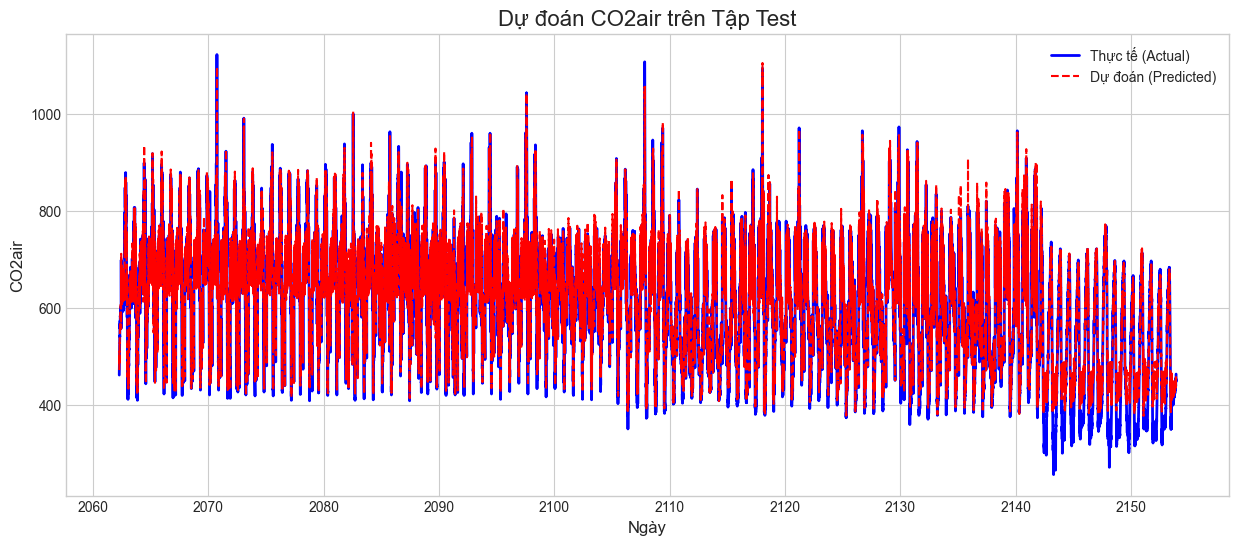

In [98]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Giả sử df_Y_raw đã được tải và làm sạch cơ bản
df_Y_raw = ds["Digilog"]["GreenhouseClimate.csv"][["CO2air"]]
df_Y_raw = df_Y_raw.interpolate(method='linear').bfill().ffill()

# --- BƯỚC 1: TẠO CHỈ SỐ THỜI GIAN (DATETIME INDEX) ---
# Giả định dữ liệu bắt đầu từ một ngày cụ thể và có tần suất hàng ngày
# Điều này là cần thiết để tạo các đặc trưng lịch
start_date = '2023-01-01'
df = df_Y_raw.copy()
df.index = pd.to_datetime(pd.date_range(start=start_date, periods=len(df), freq='D'))
target_col = 'CO2air'

# --- BƯỚC 2: HÀM TẠO FEATURE TỪ CHUỖI THỜI GIAN ---
def create_time_series_features(df, target_col):
    """
    Tạo ra một bộ đặc trưng phong phú từ một chuỗi thời gian đơn biến.
    """
    df_featured = df.copy()
    
    # -- 1. Lag Features --
    # Lấy các giá trị từ 1, 2, 3, và 7 ngày trước (tuần trước)
    for i in [1, 2, 3, 7, 14]:
        df_featured[f'{target_col}_lag_{i}'] = df_featured[target_col].shift(i)

    # -- 2. Rolling Window Features --
    # Sử dụng cửa sổ 7 ngày để nắm bắt xu hướng tuần
    window_size = 7
    df_featured[f'{target_col}_roll_mean_{window_size}'] = df_featured[target_col].shift(1).rolling(window=window_size).mean()
    df_featured[f'{target_col}_roll_std_{window_size}'] = df_featured[target_col].shift(1).rolling(window=window_size).std()
    df_featured[f'{target_col}_roll_max_{window_size}'] = df_featured[target_col].shift(1).rolling(window=window_size).max()
    df_featured[f'{target_col}_roll_min_{window_size}'] = df_featured[target_col].shift(1).rolling(window=window_size).min()

    # -- 3. Date-based Features --
    df_featured['dayofweek'] = df_featured.index.dayofweek # Thứ trong tuần (0=Thứ 2, 6=Chủ Nhật)
    df_featured['weekofyear'] = df_featured.index.isocalendar().week.astype(int) # Tuần trong năm
    df_featured['month'] = df_featured.index.month # Tháng
    df_featured['dayofyear'] = df_featured.index.dayofyear # Ngày trong năm
    df_featured['is_weekend'] = (df_featured.index.dayofweek >= 5).astype(int) # Có phải cuối tuần không?

    # Loại bỏ các hàng có giá trị NaN được tạo ra bởi shift và rolling
    df_featured = df_featured.dropna()
    
    return df_featured

# Áp dụng hàm để tạo features
df_final = create_time_series_features(df, target_col)

print("--- Dữ liệu sau khi tạo features và loại bỏ NaN ---")
print(f"Hình dạng dữ liệu cuối cùng: {df_final.shape}")
print(df_final.head())


# --- BƯỚC 3: CHUẨN BỊ DỮ LIỆU CHO MÔ HÌNH ---
# Biến mục tiêu 'y' là cột ElecHigh gốc
y = df_final[target_col]
# Các đặc trưng 'X' là tất cả các cột còn lại
X = df_final.drop(columns=[target_col])


# --- BƯỚC 4: CHIA TRAIN/TEST THEO THỨ TỰ THỜI GIAN ---
print("\n--- Bước 4: Chia Train/Test theo thời gian ---")
split_idx = int(len(X) * 0.3)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Kích thước tập Train: X={X_train.shape}, y={y_train.shape}")
print(f"Kích thước tập Test: X={X_test.shape}, y={y_test.shape}")


# --- BƯỚC 5: HUẤN LUYỆN VÀ ĐÁNH GIÁ MÔ HÌNH RANDOM FOREST ---
print("\n--- Bước 5: Huấn luyện và Đánh giá Random Forest ---")

# Random Forest không nhạy cảm với việc scale nên có thể bỏ qua bước này
model_rf_univariate = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True)
model_rf_univariate.fit(X_train, y_train)

# Đánh giá trên tập test
test_pred = model_rf_univariate.predict(X_test)
test_r2 = r2_score(y_test, test_pred)

print(f"\nOut-of-Bag (OOB) R² Score: {model_rf_univariate.oob_score_:.4f}")
print(f"Test R² Score: {test_r2:.4f}")


# --- BƯỚC 6: PHÂN TÍCH KẾT QUẢ ---
print("\n--- Bước 6: Phân tích ---")

# 1. Phân tích tầm quan trọng của Feature
feature_importances = pd.Series(model_rf_univariate.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

print("\nTop 15 features quan trọng nhất:")
print(feature_importances.head(15))

# 2. Trực quan hóa kết quả dự đoán
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(y_test.index, y_test, label='Thực tế (Actual)', color='blue', linewidth=2)
ax.plot(y_test.index, test_pred, label='Dự đoán (Predicted)', color='red', linestyle='--')
ax.set_title('Dự đoán CO2air trên Tập Test', fontsize=16)
ax.set_xlabel('Ngày', fontsize=12)
ax.set_ylabel('CO2air', fontsize=12)
ax.legend()
plt.show()

Đang đọc và làm sạch dữ liệu từ: ../Digilog

Đã tải và làm sạch thành công 8 tệp cho đội 'Digilog'.

Bắt đầu gộp và tiền xử lý dữ liệu...
Gộp dữ liệu gốc hoàn tất.

Áp dụng kỹ thuật sai phân để xử lý dữ liệu không ổn định...
Tạo dữ liệu sai phân và đặc trưng hoàn tất.
Kích thước bộ dữ liệu mới: (162, 35)

--- Bắt đầu huấn luyện cho Heat_cons (dự đoán Heat_cons_diff) ---
Tập huấn luyện: 48 mẫu, Tập kiểm tra: 114 mẫu
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 8
[LightGBM] [Info] Start training from score 0.025969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

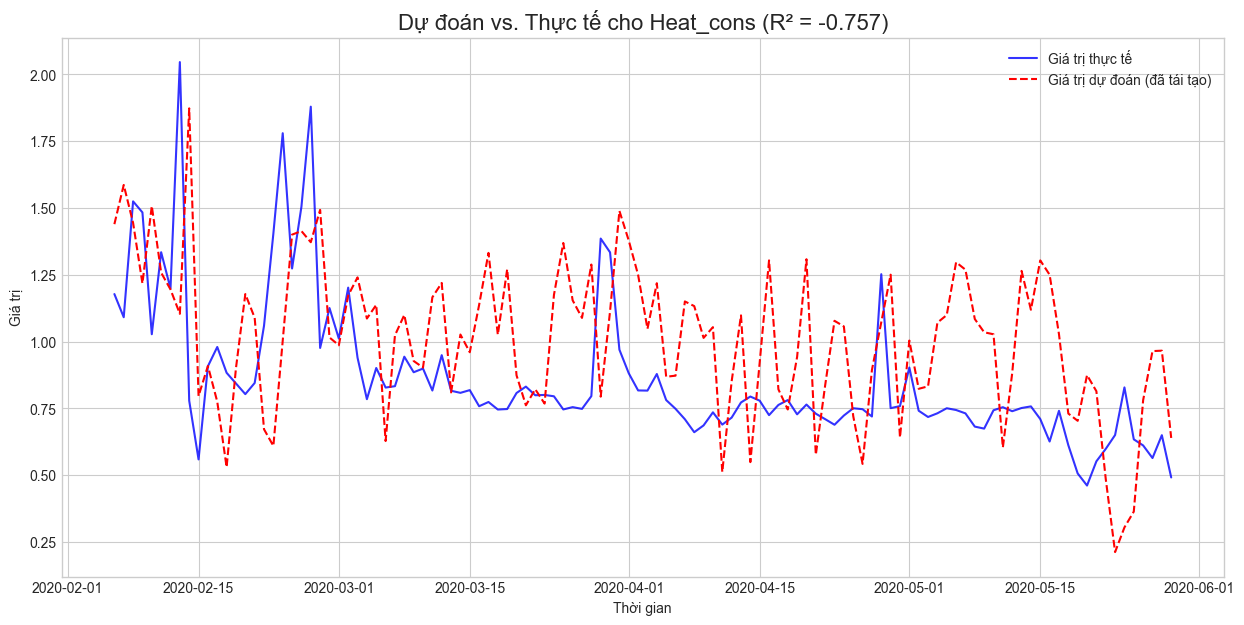

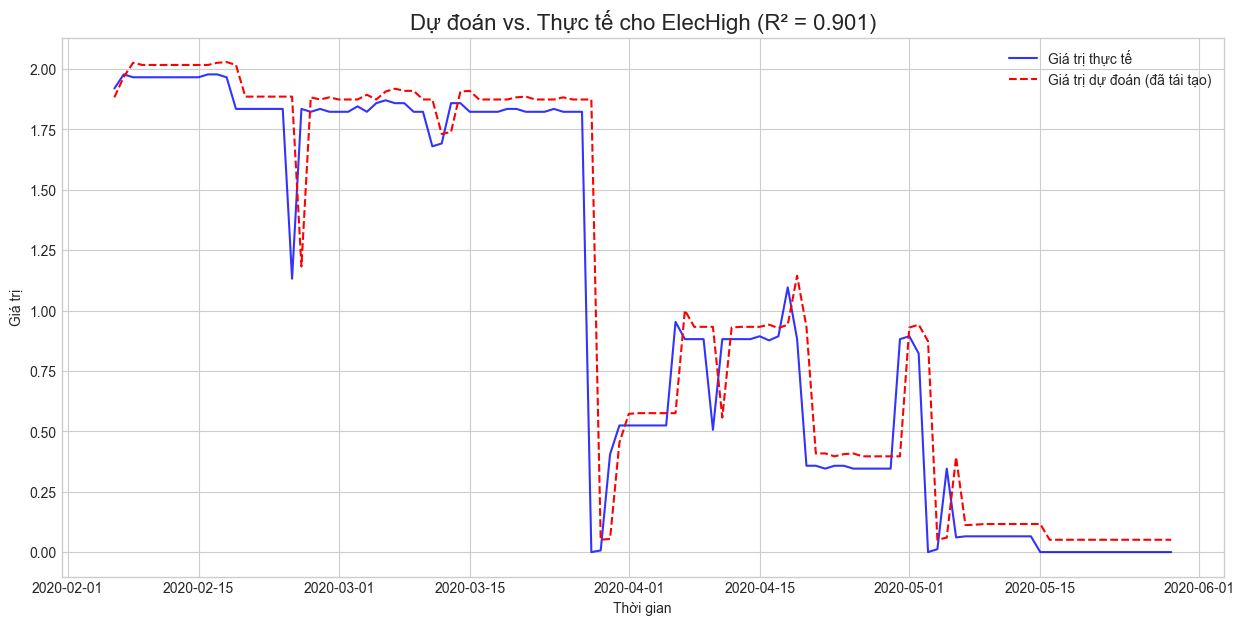

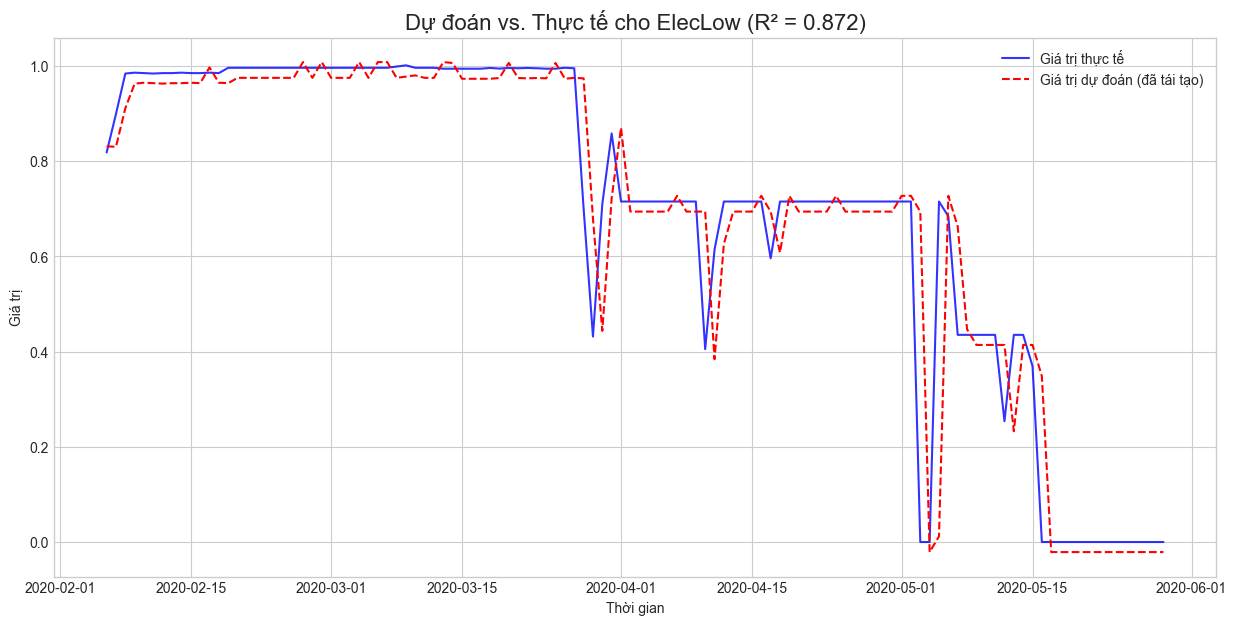

In [ ]:
# 1. SETUP AND IMPORTS
# ==============================================================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')


# 2. DATA LOADING & AUTOMATIC CLEANING (Không thay đổi)
# ==============================================================================
def read_and_clean_dataset(folder_path):
    data_dict = {}
    print(f"Đang đọc và làm sạch dữ liệu từ: {folder_path}")
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Thư mục không tồn tại: {folder_path}")
        
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            cleaned_columns = {col: col.strip().lstrip('%').strip() for col in df.columns}
            df.rename(columns=cleaned_columns, inplace=True)
            data_dict[filename] = df
    return data_dict

BASE_DATA_PATH = "../" 
TEAM_TO_ANALYZE = "Digilog"

team_folder_path = os.path.join(BASE_DATA_PATH, TEAM_TO_ANALYZE)
team_data = read_and_clean_dataset(team_folder_path)

print(f"\nĐã tải và làm sạch thành công {len(team_data)} tệp cho đội '{TEAM_TO_ANALYZE}'.")


# 3. DATA MERGING & PREPROCESSING (Không thay đổi)
# ==============================================================================
print("\nBắt đầu gộp và tiền xử lý dữ liệu...")
df_climate = team_data['GreenhouseClimate.csv'].copy()
df_weather = team_data['Weather.csv'].copy()
df_resources = team_data['Resources.csv'].copy()

for df, name in [(df_climate, 'Climate'), (df_weather, 'Weather'), (df_resources, 'Resources')]:
    time_col = next((col for col in df.columns if col.lower() == 'time'), None)
    if time_col:
        df[time_col] = pd.to_numeric(df[time_col], errors='coerce')
        df['datetime'] = pd.to_datetime(df[time_col], unit='D', origin='1899-12-30')
        df.set_index('datetime', inplace=True)
        df.drop(columns=[time_col], inplace=True)
    else:
        raise KeyError(f"LỖI: Không tìm thấy cột 'Time' trong {name}.csv")

df_original = df_resources.join([df_climate, df_weather], how='inner')
for col in df_original.columns:
    df_original[col] = pd.to_numeric(df_original[col], errors='coerce')

df_original.dropna(axis=1, how='all', inplace=True)
df_original.ffill(inplace=True)
print("Gộp dữ liệu gốc hoàn tất.")


# 4. CHIẾN LƯỢC MỚI: TẠO DỮ LIỆU SAI PHÂN (DIFFERENCING)
# ==============================================================================
print("\nÁp dụng kỹ thuật sai phân để xử lý dữ liệu không ổn định...")

# Lấy sai phân cho các biến mục tiêu và các biến có xu hướng
df = pd.DataFrame(index=df_original.index)

# Các cột cần sai phân (bao gồm cả target và feature)
cols_to_diff = ['Heat_cons', 'ElecHigh', 'ElecLow', 'Tout', 'Tair', 'Iglob', 'PipeLow', 'PipeGrow', 'Rhair']

for col in cols_to_diff:
    if col in df_original.columns:
        df[f'{col}_diff'] = df_original[col].diff()

# Các cột không cần sai phân (vì chúng không có xu hướng hoặc đã ổn định)
# Ví dụ: setpoints, cyclical features, actuators status
cols_to_keep_original = [
    't_heat_sp', 'Assim_sp', 'AssimLight', 'int_blue_sp', 'int_red_sp', 
    'int_farred_sp', 'int_white_sp', 'Windsp'
]

for col in cols_to_keep_original:
    if col in df_original.columns:
        df[col] = df_original[col]

# Tạo các đặc trưng thời gian
df['hour'] = df.index.hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_of_year'] = df.index.dayofyear

# Tạo lag features TRÊN DỮ LIỆU ĐÃ SAI PHÂN
for col in ['Heat_cons_diff', 'ElecHigh_diff', 'ElecLow_diff', 'Tair_diff', 'Tout_diff']:
     if col in df.columns:
        for i in range(1, 4):
            df[f'{col}_lag_{i}'] = df[col].shift(i)

# Bỏ các dòng NaN được tạo ra do .diff() và .shift()
df.dropna(inplace=True)
print("Tạo dữ liệu sai phân và đặc trưng hoàn tất.")
print(f"Kích thước bộ dữ liệu mới: {df.shape}")


# 5. MODELING VỚI DỮ LIỆU SAI PHÂN
# ==============================================================================
def train_and_evaluate_diff(target_name, features, data, original_data):
    """
    Huấn luyện mô hình trên dữ liệu sai phân, sau đó chuyển đổi ngược để đánh giá.
    """
    target_diff = f'{target_name}_diff'
    print(f"\n--- Bắt đầu huấn luyện cho {target_name} (dự đoán {target_diff}) ---")
    
    available_features = [f for f in features if f in data.columns]
    X = data[available_features]
    y = data[target_diff]
    
    # Chia train/test theo thời gian
    split_index = int(len(X) * 0.3)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    
    print(f"Tập huấn luyện: {len(X_train)} mẫu, Tập kiểm tra: {len(X_test)} mẫu")
    
    # Huấn luyện mô hình
    lgbm = lgb.LGBMRegressor(random_state=42)
    lgbm.fit(X_train, y_train)

    rf = RandomForestRegressor(n_estimators=100,random_state=42)
    rf.fit(X_train, y_train)

    # Dự đoán giá trị sai phân (_diff)
    y_pred_diff = lgbm.predict(X_test)
    previous_actual_values = original_data[target_name].loc[y_test.index].shift(1)
    # Giá trị đầu tiên của chuỗi test cần giá trị cuối cùng của chuỗi train
    first_test_timestamp = y_test.index[0]
    last_train_timestamp_index = original_data.index.get_loc(first_test_timestamp) - 1
    last_train_value = original_data[target_name].iloc[last_train_timestamp_index]
    previous_actual_values.iloc[0] = last_train_value
    y_pred_reconstructed = previous_actual_values + y_pred_diff
    
    # Lấy giá trị thực tế (không sai phân) để so sánh
    y_actual_original = original_data[target_name].loc[y_test.index]
    
    # Đánh giá trên dữ liệu đã được tái tạo    rmse = np.sqrt(mean_squared_error(y_actual_original, y_pred_reconstructed))
    r2 = r2_score(y_actual_original, y_pred_reconstructed)
    print(f"KẾT QUẢ CHO {target_name}:")
    print(f"  Test RMSE (trên giá trị gốc): {rmse:.4f}")
    print(f"  Test R² (trên giá trị gốc): {r2:.4f}  <-- HY VỌNG SỐ NÀY SẼ DƯƠNG!")
    
    # Trả về kết quả để vẽ biểu đồ
    results = {
        'model': lgbm,
        'y_actual': y_actual_original,
        'y_pred': y_pred_reconstructed,
        'r2_score': r2
    }
    return results

# --- Định nghĩa các bộ đặc trưng cho mô hình sai phân ---
heat_features_diff = [
    'Tout_diff', 'Tair_diff', 'Iglob', 'Windsp', 'PipeLow_diff', 'Rhair_diff', 
    't_heat_sp', # setpoints giữ nguyên
    'hour_sin', 'hour_cos',
    'Heat_cons_diff_lag_1', 'Heat_cons_diff_lag_2', 'Tair_diff_lag_1'
]

elec_features_diff = [
    'Iglob', 'PARout', 'Assim_sp', 'AssimLight', 'int_blue_sp', 'int_red_sp',
    'hour_sin', 'hour_cos', 'day_of_year',
    'ElecHigh_diff_lag_1', 'ElecLow_diff_lag_1', 'Iglob_lag_1' # I glob không cần diff
]

# --- Chạy mô hình ---
heat_results = train_and_evaluate_diff('Heat_cons', heat_features_diff, df, df_original)
elechigh_results = train_and_evaluate_diff('ElecHigh', elec_features_diff, df, df_original)
eleclow_results = train_and_evaluate_diff('ElecLow', elec_features_diff, df, df_original)


# 6. VISUALIZE RESULTS
# ==============================================================================
def plot_reconstructed_predictions(results, target_name):
    """Vẽ biểu đồ so sánh giá trị thực tế và giá trị dự đoán đã tái tạo."""
    plt.figure(figsize=(15, 7))
    plt.plot(results['y_actual'], label='Giá trị thực tế', color='blue', alpha=0.8)
    plt.plot(results['y_pred'], label='Giá trị dự đoán (đã tái tạo)', color='red', linestyle='--')
    
    plt.title(f'Dự đoán vs. Thực tế cho {target_name} (R² = {results["r2_score"]:.3f})', fontsize=16)
    plt.xlabel('Thời gian')
    plt.ylabel('Giá trị')
    plt.legend()
    plt.grid(True)
    plt.show()

print("\n--- Hiển thị kết quả trực quan ---")
plot_reconstructed_predictions(heat_results, 'Heat_cons')
plot_reconstructed_predictions(elechigh_results, 'ElecHigh')
plot_reconstructed_predictions(eleclow_results, 'ElecLow')
